# Desion Tree Classifiers

In [0]:
import pandas as pd

# the two models we will be working with today
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

In [0]:
df = pd.read_csv('https://gist.githubusercontent.com/aaron-gu/a6f9ad745516e87fc2f2db9aa5520480/raw/682c6f3bd236210e44dc04c0bb879ef7d894b294/titanic.csv', header=0)
df.head()

,PassengerId,Survived,PassengerClass,Name,Sex,Age,SiblingsSpousesAboard,ParentsChildrenAboard,TicketNum,Fare,Cabin,PortEmbarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
df.shape

(891, 13)

# Decision Tree

First, we have to convert the categorical features into numerical features, since the decision tree does not accept categories. This process is called **feature engineering**.

Let's engineer the `Name`, `Sex`, `PassengerClass`, and `Cabin` columns. There is way more you could extract from other features, but we will leave that to you! 

### Cabin column into categories

Now let's get the cabin that each passenger was in and convert it into categories.

The first letter represents the cabin, and we can discard the number after it.

In [0]:
df['Cabin'] = df['Cabin'].apply(lambda x: x[0] if type(x) == str else "NA")

### Name column into categories

This one involves a complex lambda function with regex, which will select exactly the part of the name string before the `.` and after the space`.

This results in the `Title` of each person, which we can visualize as a barplot.

In [0]:
df['Title'] = df['Name'].apply(lambda x: x.split(', ')[1].split(' ')[0])

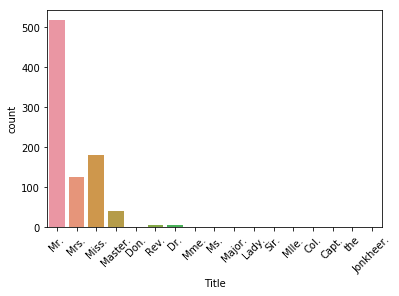

In [0]:
import re
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='Title', data=df)
plt.xticks(rotation=45)
plt.show()

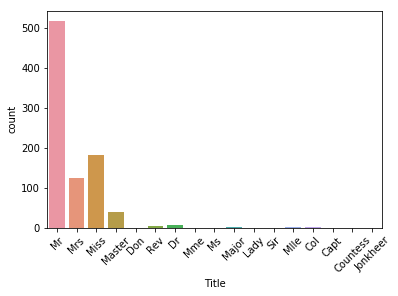

In [0]:
import re
import seaborn as sns
import matplotlib.pyplot as plt

df['Title'] = df['Name'].apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
sns.countplot(x='Title', data=df)
plt.xticks(rotation=45)
plt.show()

We will replace the less common titles with "Special", and group titles like 'Mlle' and 'Mme' together.

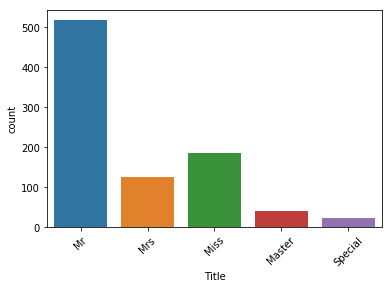

In [0]:
df['Title'] = df['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'})
df['Title'] = df['Title'].replace(['Don', 'Dona', 'Rev', 'Dr',
                                            'Major', 'Lady', 'Sir', 'Col', 'Capt', 'Countess', 'Jonkheer'],'Special')
sns.countplot(x='Title', data=df)
plt.xticks(rotation=45)
plt.show()

In [0]:
df.head()

,PassengerId,Survived,PassengerClass,Name,Sex,Age,SiblingsSpousesAboard,ParentsChildrenAboard,TicketNum,Fare,Cabin,PortEmbarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NA,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NA,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NA,S,Mr


In [0]:
x = pd.get_dummies(df[['Sex', 'Cabin', 'Title', 'PassengerClass']])
y = df['Survived']

In [0]:
x.head()

,PassengerClass,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_NA,Cabin_T,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Special
0,3,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,3,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,3,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [0]:
# model
tree = DecisionTreeClassifier(random_state=2, min_samples_leaf=5, min_samples_split=20)

# train
# if you don't do proper feature engineering and get_dummies, you'll get a message like:
# ValueError: could not convert string to float: 'Uruchurtu, Don. Manuel E'
tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=2, splitter='best')

In [0]:
# score

print(tree.score(x_train, y_train))
print(tree.score(x_test, y_test))
print(accuracy_score(tree.predict(x_test), y_test)) # sklearn.metrics.accuracy_score is the same as tree.score

0.8061797752808989
0.7597765363128491
0.7597765363128491


### Feature Importances

The ".feature\_importances\_" attribute of the DecisionTreeClassifier() object gives us the information gain of each attribute as a measure of importance.

In [0]:
tree.feature_importances_

array([1.61446777e-01, 1.47058530e-03, 6.44256416e-03, 9.40485819e-03,
       9.33939010e-04, 3.53353331e-03, 0.00000000e+00, 2.67127598e-03,
       7.25491573e-03, 0.00000000e+00, 8.10495159e-02, 2.10241762e-03,
       2.93377239e-04, 8.49260304e-03, 6.40151733e-01, 5.21967004e-04,
       7.42299376e-02])

Looks like the decision tree mainly used `petal_width` to predict the species.

In [0]:
# I put the attribute names and their respective information gains in a data frame for readability.
gain_df = pd.DataFrame({'Gain': tree.feature_importances_}, index=x_train.columns).sort_values('Gain', ascending = False)
gain_df

,Gain
Title_Mr,0.684765
PassengerClass,0.167375
Title_Special,0.079403
Cabin_NA,0.044576
Cabin_F,0.007761
Cabin_A,0.006232
Cabin_E,0.002815
Cabin_C,0.001787
Cabin_D,0.001479
Title_Mrs,0.001215


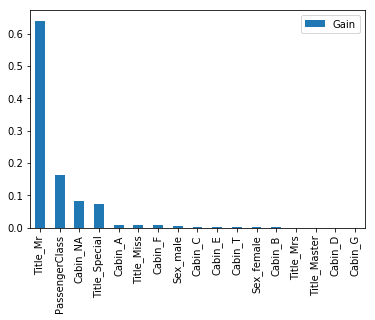

In [0]:
gain_df.plot(kind='bar')
plt.show()

### Confusion Matrix

A confusion matrix is a good way to check the accuracy of your model and to see in what ways your model may be predicting incorrectly.

We do this using the Pandas `crosstab()` function or the sklearn `confusion_matrix()` function.

In [0]:
pd.crosstab(y_test, tree.predict(x_test), rownames=['Actual'], colnames = ['Predicted:'], margins=True)

Predicted:,0,1,All
Actual,,,
0,97,3,100
1,39,40,79
All,136,43,179


### Decision Tree Visualization

do not memorize this code, just copy paste it

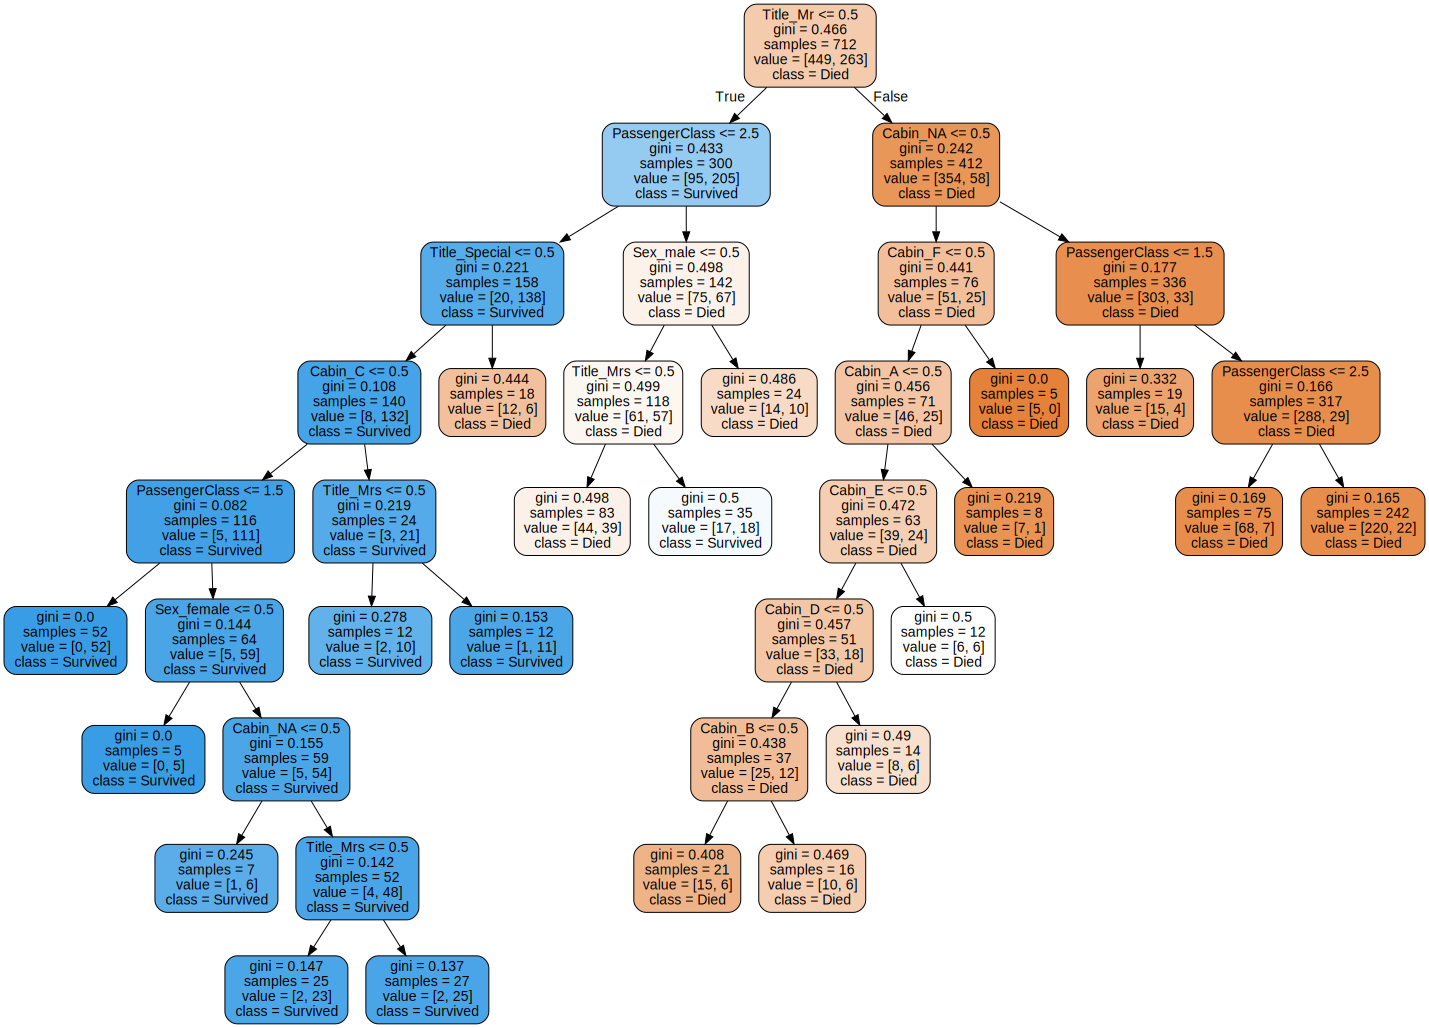

In [0]:
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from google.colab import files

graph = Source(export_graphviz(tree,
                        out_file=None,
                        feature_names=x_train.columns,
                        class_names=['Died', 'Survived'],
                        filled=True,
                        rounded=True))

# save to file
png_bytes = graph.pipe(format='png')
with open('tree.png', 'wb') as f:
  f.write(png_bytes)
files.download('tree.png')

# display in notebook
SVG(graph.pipe(format='svg'))

# Random Forest

In [0]:
# model
forest = RandomForestClassifier(random_state=2)
# many other criterion that you can look into

# train
forest.fit(x_train, y_train)

# predict
forest_predictions = forest.predict(x_test)

# feature importances
importance_df = pd.DataFrame({'Importance': forest.feature_importances_}, index = x_train.columns).sort_values('Importance', ascending = False)

# confusion matrix
pd.crosstab(y_test, forest_predictions, rownames=['Actual'], colnames = ['Predicted:'], margins = True)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Predicted:,0,1,All
Actual,,,
0,94,6,100
1,36,43,79
All,130,49,179


In [0]:
forest.score(x_test, y_test)

0.7653631284916201

# On your own

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns

In [0]:
dataset_url = 'http://mlr.cs.umass.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(dataset_url, sep=';')

In [18]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Recode the quality column (what we want to predict) into a classification variable (good, average, bad)

In [19]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Create a decision tree and random forest to predict quality. Compare results.

In [20]:
data['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [0]:
def conversion(x):
  if x > 6.5:
    return 'good'
  elif 5.5 <= x <= 6.5:
    return 'average'
  elif x < 5.5:
    return 'bad'

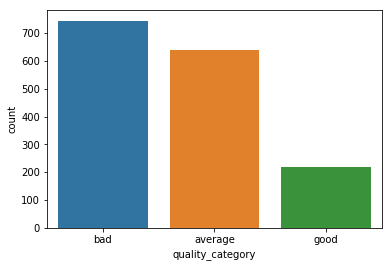

In [22]:
data['quality_category'] = data['quality'].apply(conversion)
sns.countplot(x='quality_category', data=data)

In [0]:
data.drop('quality', axis=1, inplace=True)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop(['quality_category'], axis=1), data['quality_category'], test_size=0.20, random_state=42)

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

# model
forest = RandomForestClassifier(random_state=2)
# many other criterion that you can look into

# train
forest.fit(X_train, y_train)

# predict
forest_predictions = forest.predict(X_test)

# feature importances
importance_df = pd.DataFrame({'Importance': forest.feature_importances_}, index = X_train.columns).sort_values('Importance', ascending = False)

# confusion matrix
pd.crosstab(y_test, forest_predictions, rownames=['Actual'], colnames = ['Predicted:'], margins = True)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Predicted:,average,bad,good,All
Actual,,,,
average,85,38,9,132
bad,35,104,2,141
good,19,2,26,47
All,139,144,37,320


In [34]:
print(forest.score(X_test, y_test))

0.671875
